In [1]:
import numpy as NP
import matplotlib.pyplot as PLT
import pandas as pd

In [2]:
Data = pd.read_csv("C:\\Users\\uchal\\Downloads\\dataframe_models.csv")
Data_df = Data.drop(labels='Year', axis=1) #to calculate stddev
Data_df.std(axis =0, skipna = True)

BCC-CSM2-M     193.638878
CanESM5_esm    275.623878
NorESM2-LM     102.236331
CESM2_esm       89.025466
MPI-ESM1-2     394.937132
EC-Earth3      141.433938
ACCESS-ESM1     90.056974
GISS-E2-1-G    180.269713
avg            174.060479
dtype: float64

In [3]:
Data['BCC-CSM2-M']

0      790.492493
1      785.358582
2      809.337830
3      732.754028
4      824.578857
         ...     
81    1350.369019
82    1346.990601
83    1452.997314
84    1359.575684
85    1359.547485
Name: BCC-CSM2-M, Length: 86, dtype: float64

In [5]:
# defining refernece data as the 'avg' column from the dataframe
X = Data.avg
X.std()

174.06047926125962

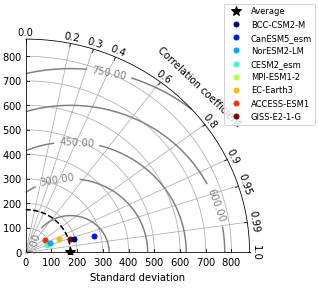

In [6]:
labels=['BCC-CSM2-M' ,'CanESM5_esm','NorESM2-LM','CESM2_esm','MPI-ESM1-2','EC-Earth3','ACCESS-ESM1','GISS-E2-1-G']
class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.
        Parameters:
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()
        
          # Correlation labels
        rlocs = NP.array([0, 0.2, 0.3, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        
         # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation coefficient")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours


def test1():
    #"""Display a Taylor diagram in a separate axis."""

    # Reference dataset - avg of models
    x = X
    data = X
    refstd = 174.0605         # Reference standard deviation data.std(ddof=1)

    # Model data
    m1 = Data['BCC-CSM2-M']    # Model 1
    m2 = Data['CanESM5_esm']       # Model 2
    m3 = Data['NorESM2-LM']  # Model 3
    m4 = Data['CESM2_esm']     #Model 4
    m5 = Data['MPI-ESM1-2']    #Model 5
    m6 = Data['EC-Earth3']     # Model 6
    m7 = Data['ACCESS-ESM1']  # Model 7
    m8 = Data['GISS-E2-1-G']   # Model 8
    #m9 = Data.sum           # Model 9

    # Compute stddev and correlation coefficient of models
    samples = NP.array([ [m.std(ddof=1), NP.corrcoef(data, m)[0, 1]]
                      for m in (m1, m2, m3, m4, m5, m6, m7, m8)])

    fig = PLT.figure(figsize=(9, 4))

#     ax1 = fig.add_subplot(1, 2, 1, xlabel='X', ylabel='Y')
    #Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="Average",
                        srange=(0, 5))

    colors = PLT.matplotlib.cm.jet(NP.linspace(0, 1, len(samples)))

#     ax1.plot(data, 'k', label='Avg')                 #to plot the timeseries
#     for i, m in enumerate([m1, m2, m3]):
#        ax1.plot(m, c=colors[i], label='Model %d' % (i+1))
#     ax1.legend(numpoints=1, prop=dict(size='small'), loc='best')

     #Add the models to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
       dia.add_sample(stddev, corrcoef,
                     marker='.', ms=10, ls='',
                     mfc=colors[i], mec=colors[i],
                     label=labels[i])

    #Add grid
    dia.add_grid()

    #Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    #Add a figure legend
    fig.legend(dia.samplePoints,
              [ p.get_label() for p in dia.samplePoints ],
             numpoints=1, prop=dict(size='small'), loc='upper right')

    return dia


# def test2():
#     """
#     Climatology-oriented example (after iteration w/ Michael A. Rawlins).
#     """

#     # Reference std
#     stdref = 174.0605

#     # Samples std,rho,name
#     samples = [[193.6389, 0.96, "BCC-CSM2-M"],
#                [275.6239, 0.85, "CanESM5_esm"],
#                [102.2363, 0.70, "NorESM2-LM"],
#               [89.0255, 0.60, "CESM2_esm"],
#               [394.9371, 0.73, "MPI-ESM1-2"],
#               [141.434, 0.49, "EC-Earth3"],
#               [90.057, 0.523, "ACCESS-ESM1"],
#               [180.2697, 0.309, "GISS-E2-1-G"]]

#     fig = PLT.figure()

#     dia = TaylorDiagram(stdref, fig=fig, label='Avg', extend=True)
#     dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

#     # Add models to Taylor diagram
#     for i, (stddev, corrcoef, name) in enumerate(samples):
#         dia.add_sample(stddev, corrcoef,
#                        marker='$%d$' % (i+1), ms=10, ls='',
#                        mfc='k', mec='k',
#                        label=name)

#     # Add RMS contours, and label them
#     contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
#     PLT.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

#     dia.add_grid()                                  # Add grid
#     dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

#     # Add a figure legend and title
#     fig.legend(dia.samplePoints,
#                [ p.get_label() for p in dia.samplePoints ],
#                numpoints=1, prop=dict(size='small'), loc='upper right')
#     fig.suptitle("Taylor diagram", size='x-large')  # Figure title

#     return dia


if __name__ == '__main__':

    dia = test1()
#     dia = test2()
#     PLT.savefig("C:\\Users\\uchal\\Downloads\\taylor_diagram.png", dpi=600)
    PLT.show()


1.8


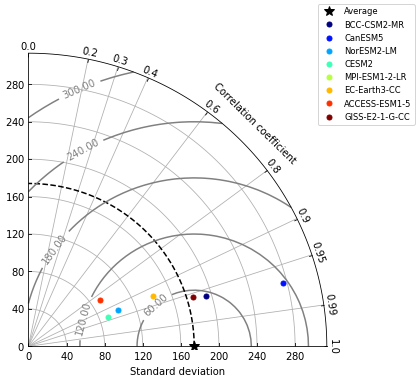

In [7]:
labels= ['BCC-CSM2-MR','CanESM5','NorESM2-LM','CESM2','MPI-ESM1-2-LR','EC-Earth3-CC','ACCESS-ESM1-5','GISS-E2-1-G-CC']

class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.8), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.
        Parameters:
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()
        
          # Correlation labels
        rlocs = NP.array([0, 0.2, 0.3, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        
         # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd
        print(srange[1])
        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation coefficient")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours


def test1():
    #"""Display a Taylor diagram in a separate axis."""

    # Reference dataset - avg of models
    x = X
    data = X
    refstd = 174.0605         # Reference standard deviation data.std(ddof=1)

    # Model data
    m1 = Data['BCC-CSM2-M']    # Model 1
    m2 = Data['CanESM5_esm']       # Model 2
    m3 = Data['NorESM2-LM']  # Model 3
    m4 = Data['CESM2_esm']     #Model 4
    m5 = Data['MPI-ESM1-2']    #Model 5
    m6 = Data['EC-Earth3']     # Model 6
    m7 = Data['ACCESS-ESM1']  # Model 7
    m8 = Data['GISS-E2-1-G']   # Model 8
    #m9 = Data.sum           # Model 9

    # Compute stddev and correlation coefficient of models
    samples = NP.array([ [m.std(ddof=1), NP.corrcoef(data, m)[0, 1]]
                      for m in (m1, m2, m3, m4, m5, m6, m7, m8)])

    fig = PLT.figure(figsize=(12,5.5))

#     ax1 = fig.add_subplot(1, 2, 1, xlabel='X', ylabel='Y')
    #Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="Average",
                        srange=(0, 1.8))

    colors = PLT.matplotlib.cm.jet(NP.linspace(0, 1, len(samples)))

#     ax1.plot(data, 'k', label='Avg')                 #to plot the timeseries
#     for i, m in enumerate([m1, m2, m3]):
#        ax1.plot(m, c=colors[i], label='Model %d' % (i+1))
#     ax1.legend(numpoints=1, prop=dict(size='small'), loc='best')

     #Add the models to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
       dia.add_sample(stddev, corrcoef,
                     marker='.', ms=10, ls='',
                     mfc=colors[i], mec=colors[i],
                     label=labels[i])

    #Add grid
    dia.add_grid()

    #Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    #Add a figure legend
    fig.legend(dia.samplePoints,
              [ p.get_label() for p in dia.samplePoints ],
             numpoints=1, prop=dict(size='small'), loc='upper right')

    return dia


# def test2():
#     """
#     Climatology-oriented example (after iteration w/ Michael A. Rawlins).
#     """

#     # Reference std
#     stdref = 174.0605

#     # Samples std,rho,name
#     samples = [[193.6389, 0.96, "BCC-CSM2-M"],
#                [275.6239, 0.85, "CanESM5_esm"],
#                [102.2363, 0.70, "NorESM2-LM"],
#               [89.0255, 0.60, "CESM2_esm"],
#               [394.9371, 0.73, "MPI-ESM1-2"],
#               [141.434, 0.49, "EC-Earth3"],
#               [90.057, 0.523, "ACCESS-ESM1"],
#               [180.2697, 0.309, "GISS-E2-1-G"]]

#     fig = PLT.figure()

#     dia = TaylorDiagram(stdref, fig=fig, label='Avg', extend=True)
#     dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

#     # Add models to Taylor diagram
#     for i, (stddev, corrcoef, name) in enumerate(samples):
#         dia.add_sample(stddev, corrcoef,
#                        marker='$%d$' % (i+1), ms=10, ls='',
#                        mfc='k', mec='k',
#                        label=name)

#     # Add RMS contours, and label them
#     contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
#     PLT.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

#     dia.add_grid()                                  # Add grid
#     dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

#     # Add a figure legend and title
#     fig.legend(dia.samplePoints,
#                [ p.get_label() for p in dia.samplePoints ],
#                numpoints=1, prop=dict(size='small'), loc='upper right')
#     fig.suptitle("Taylor diagram", size='x-large')  # Figure title

#     return dia


if __name__ == '__main__':

    dia = test1()
#     dia = test2()
    PLT.savefig("C:\\Users\\uchal\\Downloads\\taylor_diagram.png", dpi=600)
    PLT.show()


# PAST_TAYLOR_DIAGRAM


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc4
import glob 
import datetime as dt
import os

In [12]:

modis_gpp=xr.open_dataset("C:\\Users\\uchal\\OneDrive\\Documents\\PROJECT_WORK\\Paper_study\\modis\\MOD17A2H.006\\MOD17A2HGF.061_500m_filtered_1by1_merged_masked.nc") 


In [9]:
file1=xr.open_dataset('C:\\Users\\uchal\\OneDrive\\Documents\\PROJECT_WORK\\Paper_study\\Past\\ACCESS-ESM1past_masked.nc')
file2=xr.open_dataset('C:\\Users\\uchal\\OneDrive\\Documents\\PROJECT_WORK\\Paper_study\\Past\\NorESM2-LM_past_masked.nc')

In [10]:
file1=file1.sel(time=slice('2000-01-16T12:00:00.000000000', '2014-12-16T12:00:00.000000000'))
file2=file2.sel(time=slice('2000-01-16T12:00:00.000000000', '2014-12-16T12:00:00.000000000'))

In [13]:
m=[]
gpp_year=file1['gpp_c'].groupby('time.year').mean()
gpp_year_mean=(gpp_year.mean('lat').mean('lon'))*365
gpp=gpp_year_mean.values
m.append(gpp)
gpp_year=file2['gpp_c'].groupby('time.year').mean()
gpp_year_mean=(gpp_year.mean('lat').mean('lon'))*365
gpp=gpp_year_mean.values
m.append(gpp)


monthly_data = modis_gpp['Gpp_day'].resample(time='1Y').mean()
mean=(monthly_data.mean('lat').mean('lon'))*365
gpp=mean.values
m.append(gpp)
y=list(range(2000,2015))
df=pd.DataFrame(m, columns=y)

a_model=df.transpose()
a_model.columns=['ACCESS-ESM1','NorESM2-LM','MODIS']
a_model
a_model.to_csv("C:\\Users\\uchal\\Downloads\\dataframe_past.csv")

In [17]:
Data = pd.read_csv("C:\\Users\\uchal\\Downloads\\dataframe_past.csv")
Data_df = Data.drop(labels='Year', axis=1) #to calculate stddev
Data_df.std(axis =0, skipna = True)

ACCESS-ESM1    27.737983
NorESM2-LM     30.849730
MODIS          40.624191
dtype: float64

In [18]:
X = Data.MODIS


[[27.73798325  0.16253881]
 [30.84972952 -0.24244217]]


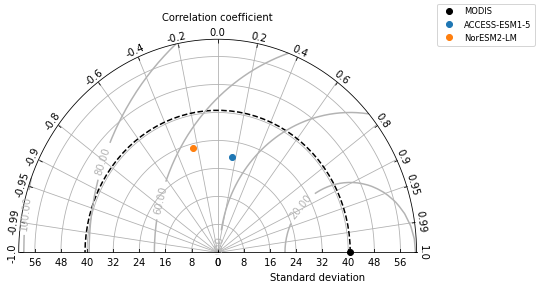

In [19]:
labels=['ACCESS-ESM1-5','NorESM2-LM']
class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=True):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.
        Parameters:
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()
        
          # Correlation labels
        rlocs = np.array([0, 0.2, 0.4, 0.6, 0.8,0.9,0.95,0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = np.pi
            rlocs = np.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = np.pi/2
        tlocs = np.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        
         # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd
        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)
        
        if fig is None:
            fig = plt.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation coefficient")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
#         ax.axis["left"].label.set_axis_direction("bottom")
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True, label=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k.',
                          ls='', ms=12, label=label)
        t = np.linspace(0, self.tmax)
        r = np.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(np.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax),
                             np.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = np.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*np.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours


def test1():
    #"""Display a Taylor diagram in a separate axis."""

    # Reference dataset - avg of models
    x = X
    data = X
    refstd = 40.624191         # Reference standard deviation data.std(ddof=1)

    # Model data
    m1 = Data['ACCESS-ESM1']
       
    m2 = Data['NorESM2-LM'] 
      

    # Compute stddev and correlation coefficient of models
    samples = np.array([ [m.std(ddof=1), np.corrcoef(data, m)[0, 1]]
                      for m in (m1, m2)])
    print(samples)
    fig = plt.figure(figsize=(16,4))

#     ax1 = fig.add_subplot(1, 2, 1, xlabel='X', ylabel='Y')
    #Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="MODIS",
                        srange=(0, 1.5))
    

     #Add the models to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                     marker='.', ms=12, ls='', 
                     label=labels[i])

    #Add grid
    dia.add_grid()

    #Add RMS contours, and label them
    contours = dia.add_contours(colors='0.7')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    #Add a figure legend
    fig.legend(dia.samplePoints,
              [ p.get_label() for p in dia.samplePoints ],
             numpoints=1, prop=dict(size='small'))

    return dia


if __name__ == '__main__':

    dia = test1()
#     plt.savefig("C:\\Users\\uchal\\Downloads\\taylor_diagram_past.jpg", dpi=600)
#     plt.savefig("C:\\Users\\uchal\\OneDrive\\Documents\\PROJECT_WORK\\Paper_study\\REVISION\\figure_11_past_taylor_diagram.png", dpi=600)


    plt.show()
